In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

import yfinance as yf

import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,LSTM,BatchNormalization,Dropout
from keras.callbacks import EarlyStopping

from sklearn.pipeline import Pipeline

import pickle

from keras.models import load_model

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = yf.download("AAPL")

[*********************100%%**********************]  1 of 1 completed


In [3]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.099058,469033600
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.093890,175884800
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.086999,105728000
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089152,86441600
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.091737,73449600


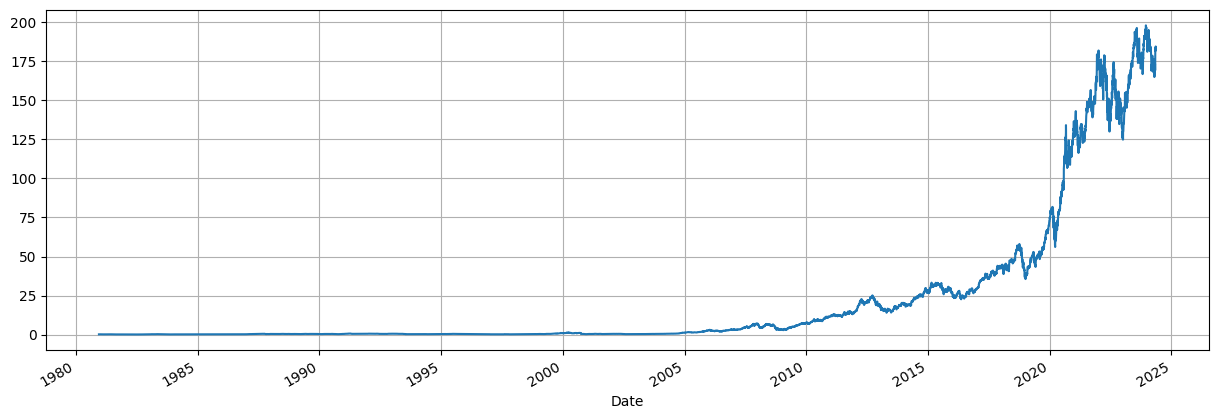

In [4]:
plt.figure(figsize = (15,5))
data['Close'].plot()
plt.grid()
plt.show()

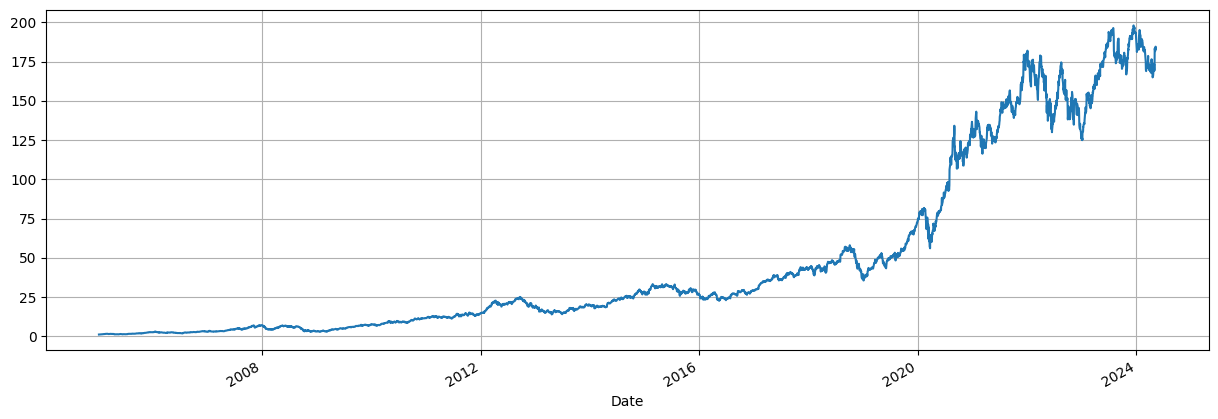

In [5]:
plt.figure(figsize = (15,5))
data['Close']['2005':].plot()
plt.grid()
plt.show()

<Figure size 1500x500 with 0 Axes>

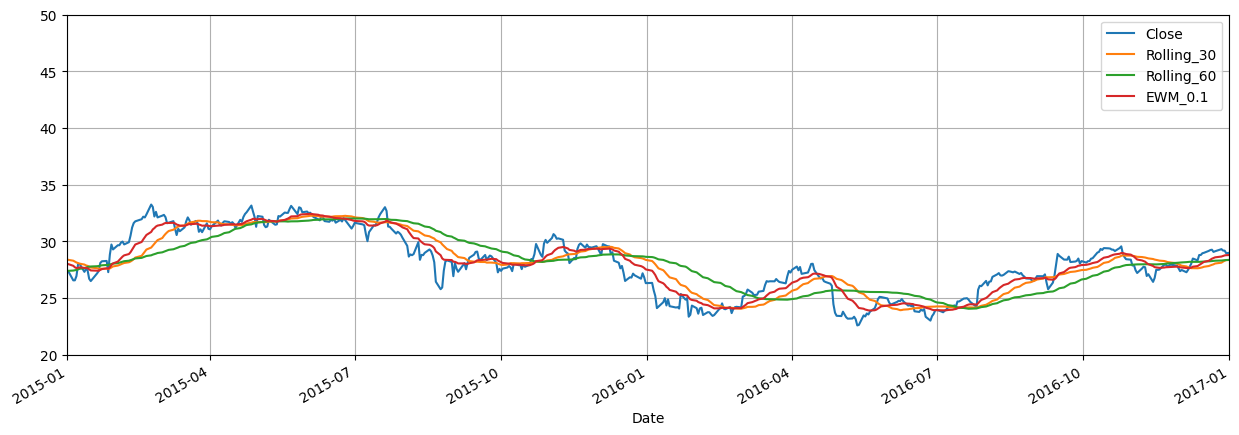

In [6]:
df = data[['Close']]
df['Rolling_30'] = df['Close'].rolling(30).mean()
df['Rolling_60'] = df['Close'].rolling(60).mean()
df['EWM_0.1'] = df['Close'].ewm(alpha = 0.1).mean()

plt.figure(figsize = (15,5))
df[['Close','Rolling_30','Rolling_60','EWM_0.1']].plot(xlim = ['2015','2017'],ylim = [20,50],figsize = (15,5))
plt.legend()
plt.grid()
plt.show()

In [7]:
df1 = df[['Close']]
df1.head()

,Close
Date,
1980-12-12,0.128348
1980-12-15,0.121652
1980-12-16,0.112723
1980-12-17,0.115513
1980-12-18,0.118862


In [8]:
def scale_data(dataframe):
    scaler = MinMaxScaler()
    scaled = pd.DataFrame(scaler.fit_transform(dataframe),columns = ['Close']).set_index(dataframe.index)
    pickle.dump(scaler,open('scaler.pkl','wb'))
    return scaled

In [9]:
def create_dataframe(dataframe,days):
    d = {}

    for i in range(days+1):
        if i != days:
            d["X"+str(i)] = []
        else:
            d['Target'] = []
    
    for j in range(days,dataframe.shape[0]):
        for k in range(days+1):
            if j-k == j:
                d['Target'].append(dataframe.iloc[j-k]['Close'])
            else:
                d['X'+str(days-k)].append(dataframe.iloc[j-k]['Close'])
    
    data = pd.DataFrame(d)
    data['Date'] = dataframe[days:].index
    data.set_index('Date',inplace=True)
    return data

In [10]:
def create_train_test(dataframe,train_per):
    train_size = int(dataframe.shape[0]*train_per)
    train = dataframe[:train_size].to_numpy()
    test = dataframe[train_size:].to_numpy()

    return train[:,:-1].reshape((len(train),train.shape[1]-1,1)).astype(np.float32),test[:,:-1].reshape((len(test),test.shape[1]-1,1)).astype(np.float32),train[:,-1].astype(np.float32),test[:,-1].astype(np.float32),dataframe[:train_size].index,dataframe[train_size:].index

In [13]:
days = 30
start_date = '2007'
train_per = 0.8

X_train,X_test,y_train,y_test,dates_train,dates_test = (df1[start_date:].
                                                pipe(scale_data).
                                                pipe(create_dataframe,days).
                                                pipe(create_train_test,train_per)
                                                )


In [12]:
df1[start_date:].shape,X_train.shape,X_test.shape,y_train.shape,y_test.shape

((4369, 1), (3471, 30, 1), (868, 30, 1), (3471,), (868,))

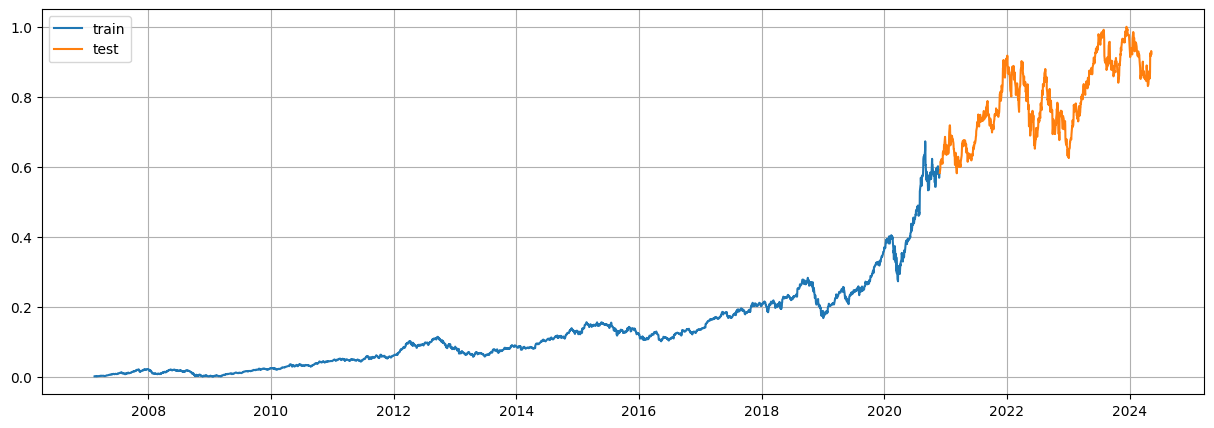

In [13]:
plt.figure(figsize = (15,5))
plt.plot(dates_train,y_train)
plt.plot(dates_test,y_test)

plt.legend(['train','test'])
plt.grid()
plt.show()

In [14]:
def plot_both_results():
    plt.figure(figsize = (20,5))
    plt.plot(dates_train,train_predict,label='Train Predicted')
    plt.plot(dates_train,y_train,label = 'Actual Train')
    plt.plot(dates_test,test_predict,label = 'Test Predicted')
    plt.plot(dates_test,y_test,label = 'Actual Test')
    plt.legend()
    plt.grid()
    plt.show()

def plot_individual_results():
    f, axs = plt.subplots(2, 1, figsize=(15, 10))

    axs[0].plot(dates_train,train_predict)
    axs[0].plot(dates_train,y_train)
    axs[0].legend(['Train Prediction','Actual Train'])
    axs[0].grid()

    axs[1].plot(dates_test,test_predict)
    axs[1].plot(dates_test,y_test)
    axs[1].legend(['Test Prediction','Actual Test'])
    axs[1].grid()

In [21]:
model = Sequential()

model.add(LSTM(64,return_sequences=True,input_shape = (days,1)))
model.add(LSTM(64))
model.add(Dense(64))
model.add(Dense(1))

model.compile(loss = 'mean_squared_error',optimizer = 'adam',metrics = ['mse'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 30, 64)            16896     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 54,145
Trainable params: 54,145
Non-trainable params: 0
_________________________________________________________________


In [22]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs = 80,verbose = 1)

Epoch 1/80
109/109 [==============================] - 5s 23ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 8.6985e-04 - val_mse: 8.6985e-04
Epoch 2/80
109/109 [==============================] - 2s 18ms/step - loss: 7.9939e-05 - mse: 7.9939e-05 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 3/80
109/109 [==============================] - 2s 19ms/step - loss: 1.2482e-04 - mse: 1.2482e-04 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 4/80
109/109 [==============================] - 2s 19ms/step - loss: 8.2849e-05 - mse: 8.2849e-05 - val_loss: 7.8564e-04 - val_mse: 7.8564e-04
Epoch 5/80
109/109 [==============================] - 2s 18ms/step - loss: 7.4400e-05 - mse: 7.4400e-05 - val_loss: 6.7088e-04 - val_mse: 6.7088e-04
Epoch 6/80
109/109 [==============================] - 2s 18ms/step - loss: 8.0003e-05 - mse: 8.0003e-05 - val_loss: 8.9199e-04 - val_mse: 8.9199e-04
Epoch 7/80
109/109 [==============================] - 2s 18ms/step - loss: 5.7904e-05 - mse: 5.7904e-05 - val_loss: 5.3767e-04 - v

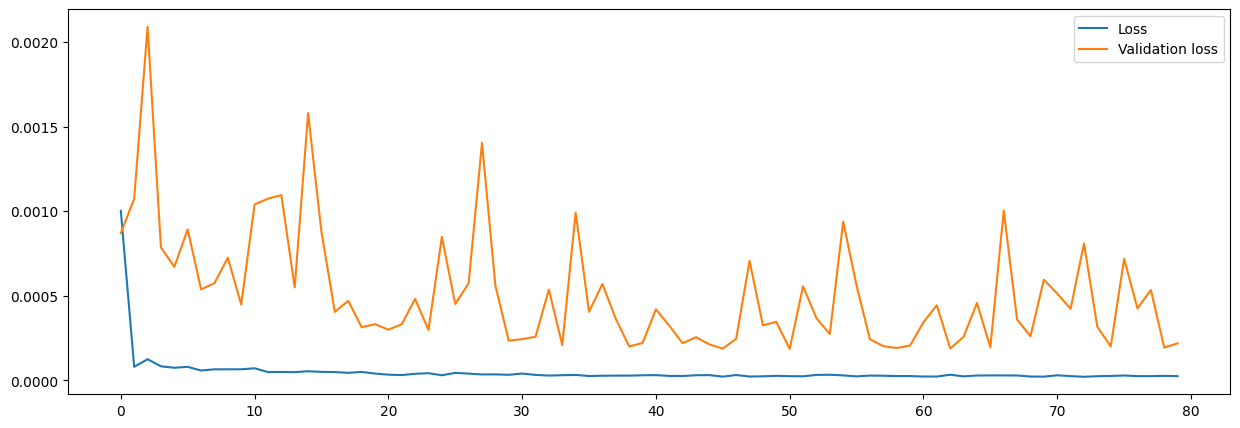

In [23]:
plt.figure(figsize = (15,5))
plt.plot(history.history['loss'],label = 'Loss')
plt.plot(history.history['val_loss'],label = 'Validation loss')
plt.legend(loc = 'best')
plt.show()

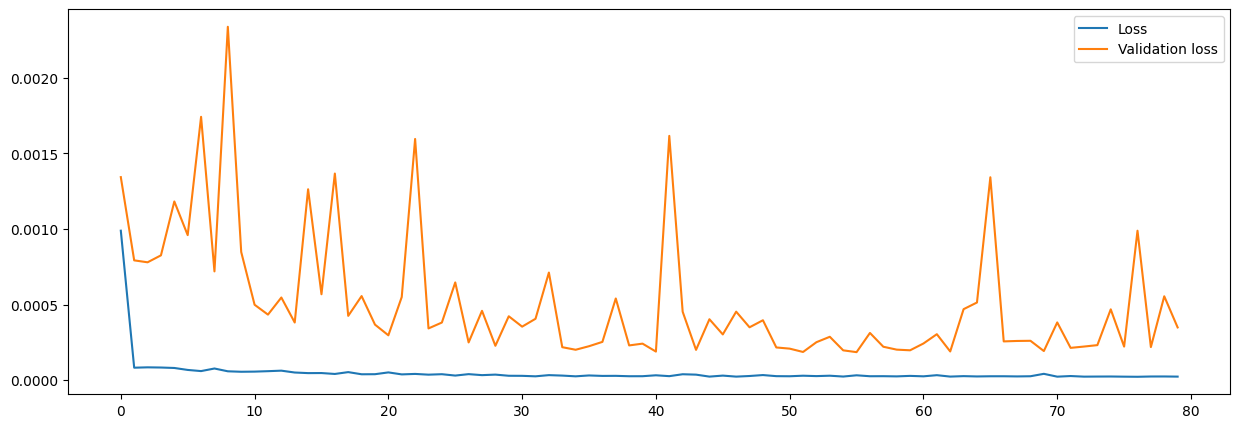

In [17]:
plt.figure(figsize = (15,5))
plt.plot(history.history['loss'],label = 'Loss')
plt.plot(history.history['val_loss'],label = 'Validation loss')
plt.legend(loc = 'best')
plt.show()

In [24]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

28/28 [==============================] - 0s 7ms/step


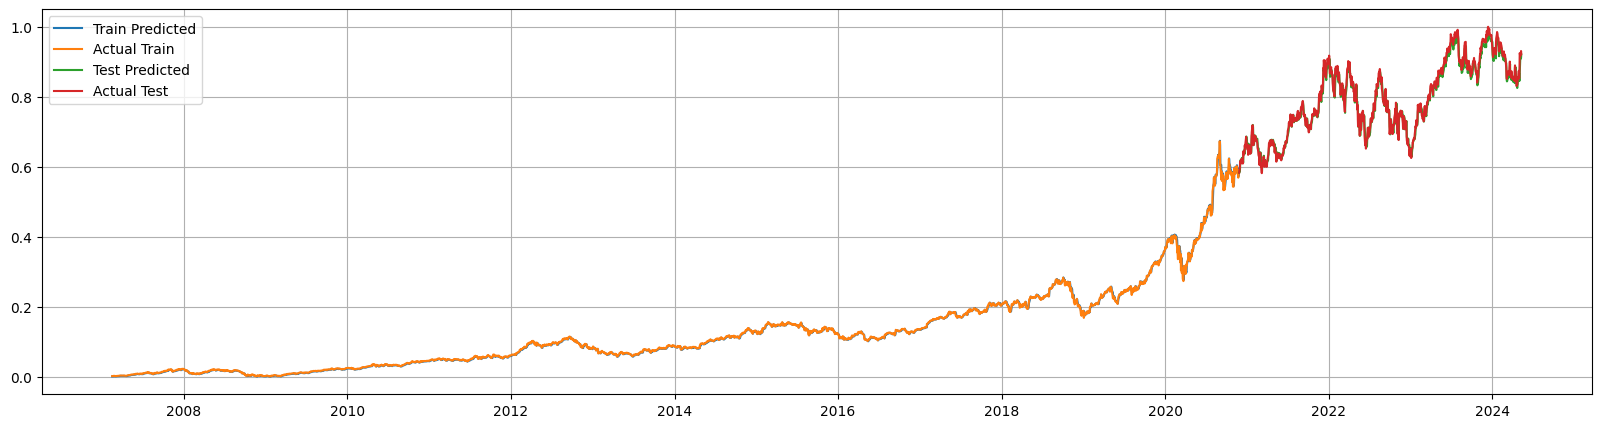

In [25]:
plot_both_results()

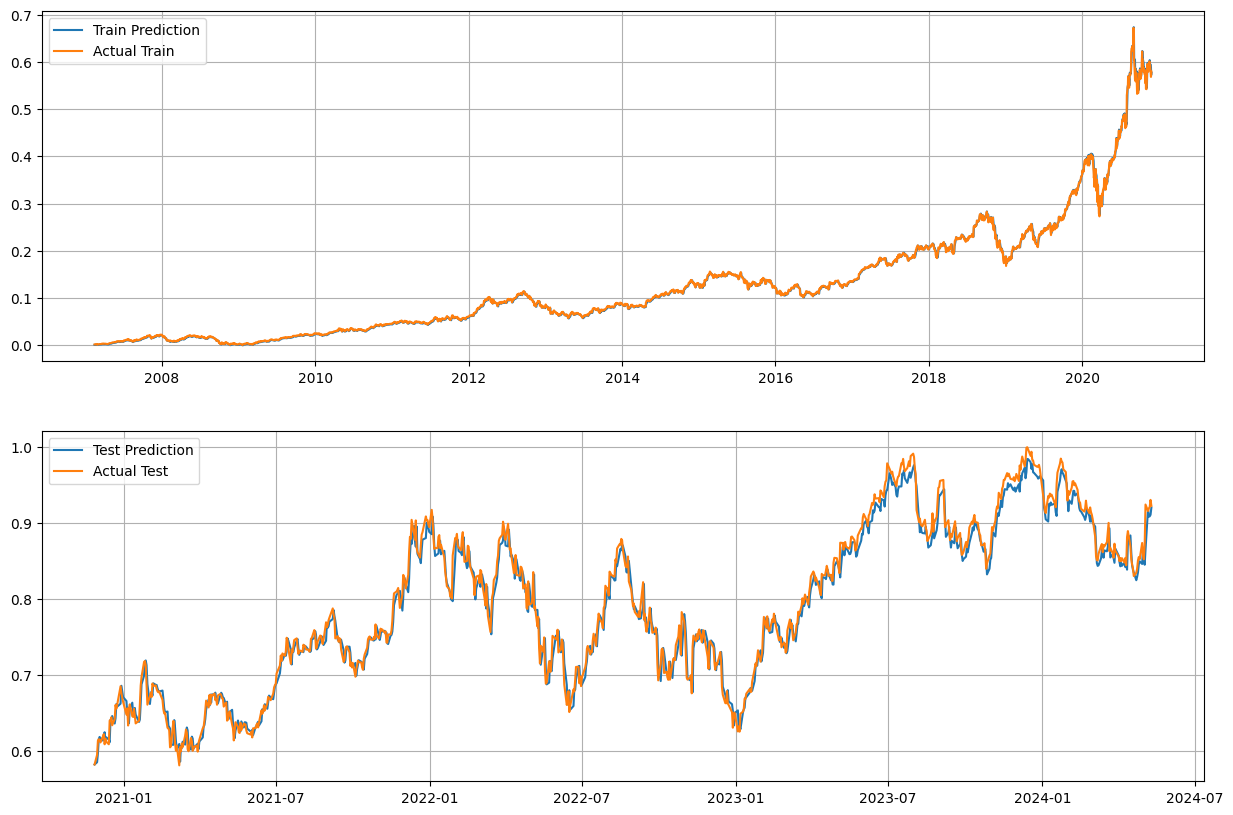

In [26]:
plot_individual_results()

In [11]:
scaler = pickle.load(open('scaler.pkl','rb'))
model = load_model('model.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 30, 64)            16896     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 54,145
Trainable params: 54,145
Non-trainable params: 0
_________________________________________________________________


In [14]:
trial = y_test[-30:].reshape(1,days,1)
pred = model.predict(trial)
scaler = pickle.load(open('scaler.pkl','rb'))
scaler.inverse_transform(pred)

1/1 [==============================] - 1s 746ms/step


array([[180.99123]], dtype=float32)

In [15]:
df2 = df1

In [20]:
def predict(dataframe):
    input_numpy = dataframe.to_numpy()
    scaled_df = scale_data(dataframe)
    last_30 = scaled_df.to_numpy()[-30:].reshape(1,days,1)
    scaled_pred = model.predict(last_30)
    pred = scaler.inverse_transform(scaled_pred)
    output = np.append(input_numpy,pred)
    return pd.DataFrame(output,columns  = ['Close'])

updated_data = predict(df2)

1/1 [==============================] - 0s 24ms/step


In [21]:
updated_data

,Close
0,0.128348
1,0.121652
2,0.112723
3,0.115513
4,0.118862
...,...
10940,182.399994
10941,182.740005
10942,184.570007
10943,183.050003


In [49]:
def predict_future(d,dataframe):
    for i in range(d):
        dataframe = predict(dataframe)
    return dataframe

d = 730

predictions = predict_future(d,df2)

1/1 [==============================] - 0s 22ms/step


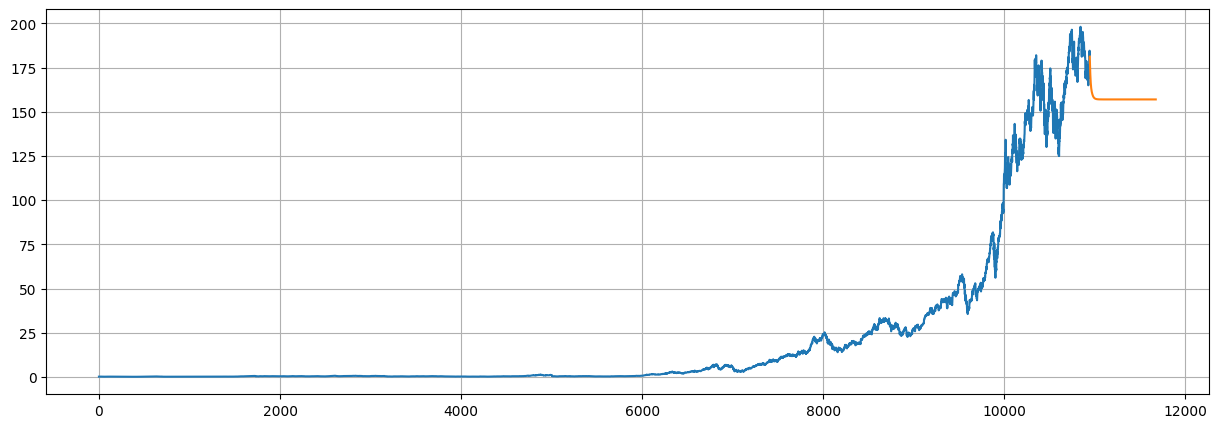

In [50]:
plt.figure(figsize=(15,5))
plt.plot(predictions[:-d])
plt.plot(predictions[-d:])
plt.grid()
plt.show()

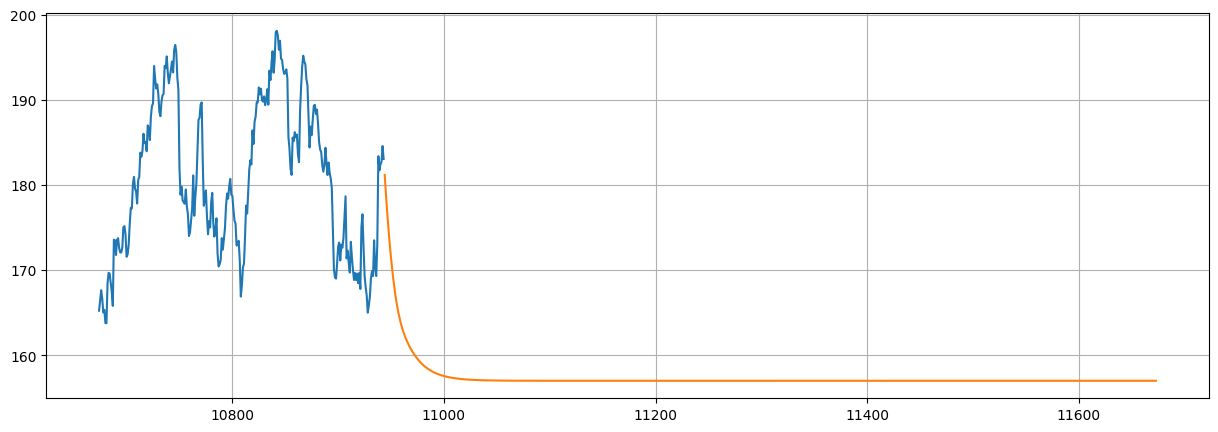

In [51]:
plt.figure(figsize=(15,5))
plt.plot(predictions[-1000:-d])
plt.plot(predictions[-d:])
plt.grid()
plt.show()

In [52]:
predictions

,Close
0,0.128348
1,0.121652
2,0.112723
3,0.115513
4,0.118862
...,...
11669,156.996506
11670,156.996490
11671,156.996490
11672,156.996490
